## The Stokes flow
#### (1.1) The governing equation 
The governing PDE is
\begin{equation}
\begin{split}
 -\mu\nabla^2{\bf u} + \nabla p &={\bf 0}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega
\end{split}
\end{equation}
where $p(N/m^2)$ is the pressure, ${\bf u} (m/s)$ is the velocity vector, ${\bf f}$ is the applied body force, $\mu$ is the dynamic viscosity.
A typical set of boundary conditions on the boundary $\partial\Omega = \Gamma_D\cup \Gamma_N$ can be:
\begin{equation}
\begin{split}
 {\bf u} = {\bf u}_0, \quad \text{on}\ \Gamma_D \\
(\nabla\cdot{\bf u}+p)\cdot\vec{n} = g\quad \text{on}\ \Gamma_N
\end{split}
\end{equation}
#### (1.2) The continuum and constitutive formulations
\begin{equation}
\begin{split}
- \nabla\cdot {\bf \sigma}  &= {\bf f}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega 
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) 
\end{equation}
is the Cauchy stress tensor, and $p=-tr({\bf \sigma})/2$.
#### (1.3) The weak form
\begin{equation}
\begin{split}
\int {\bf \sigma} \cdot\nabla^T\psi ~dx =  \int {\bf f}\psi~dx
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) ,
\end{equation}
and $p=-tr({\bf \sigma})/2$.
#### (1.4) The problem
The domain is given in the following figure and the initial/boundary conditions are given as:
- **In flow:** ${\bf u}=(a, 0)$
- **Out flow:** $p=0$
- **non-slip wall:** ${\bf u}={\bf 0}$
- **Cylinder:** ${\bf u=0}$
  
For the parameters in the equation, we set  $\mu=0.01$.

### (1) Prepare data

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import random
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
tag = 'tanhBeta64_X'
####################################
# Load data
####################################
data_train = h5py.File('../../Problems/StokesFlow_2d/stokes_train.mat', 'r')
data_test = h5py.File('../../Problems/StokesFlow_2d/stokes_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 1781)
    beta1 = np2tensor(np.array(data["beta1"][n0:n0+ndata]), dtype)
    beta2 = np2tensor(np.array(data["beta2"][n0:n0+ndata]), dtype)
    u = np2tensor(np.array(data["u"][n0:n0+ndata,...]), dtype)
    v = np2tensor(np.array(data["v"][n0:n0+ndata,...]), dtype)
    p = np2tensor(np.array(data["p"][n0:n0+ndata,...]), dtype)
    gridx = np2tensor(np.array(data["gridx"]))
    #
    u = u.reshape(ndata, -1, 1)
    v = v.reshape(ndata, -1, 1)
    p = p.reshape(ndata, -1, 1)
    uv = torch.cat([u,v], dim=-1)
    x = gridx.repeat((ndata, 1, 1))
    
    return uv, p, x, beta1, beta2, gridx
#
uv_train, p_train, x_train, beta1_train, beta2_train, gridx = get_data(data_train, n_train, dtype)
uv_test, p_test, x_test, beta1_test, beta2_test, gridx = get_data(data_test, n_test, dtype)
#
print('The shape of uv_train:', uv_train.shape)
print('The shape of p_train:', p_train.shape)
print('The shape of x_train:', x_train.shape)
print('The shape of beta1_train:', beta1_train.shape, 'beta2_trian:', beta2_train.shape)
print('The shape of uv_test:', uv_test.shape)
print('The shape of p_test:', p_test.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of beta1_test:', beta1_test.shape, 'beta2_test:', beta2_test.shape)
print('The shape of gridx:', gridx.shape)
######################################
# Setups of the problem 
######################################
from Utils.GenPoints import Point2D
N_in, N_bd_each_edge = 400, 256
#
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype, random_seed=random_seed)
# The inner points
x_in_train = pointGen.inner_point(num_sample_or_mesh=N_in, method='hypercube')
# The boundary points
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='mesh')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#
x_inflow = x_lt
x_outflow = x_rt
x_wall = torch.cat((x_up, x_bt), axis=0)
#
print('x_in_train shape', x_in_train.shape)
print('x_inflow shape', x_inflow.shape)
print('x_outflow shape', x_outflow.shape)
print('x_wall shape:', x_wall.shape)

<KeysViewHDF5 ['beta1', 'beta2', 'gridx', 'p', 'u', 'v']>
<KeysViewHDF5 ['beta1', 'beta2', 'gridx', 'p', 'u', 'v']>
The shape of uv_train: torch.Size([1000, 2066, 2])
The shape of p_train: torch.Size([1000, 2066, 1])
The shape of x_train: torch.Size([1000, 2066, 2])
The shape of beta1_train: torch.Size([1000]) beta2_trian: torch.Size([1000])
The shape of uv_test: torch.Size([200, 2066, 2])
The shape of p_test: torch.Size([200, 2066, 1])
The shape of x_test: torch.Size([200, 2066, 2])
The shape of beta1_test: torch.Size([200]) beta2_test: torch.Size([200])
The shape of gridx: torch.Size([2066, 2])
x_in_train shape torch.Size([400, 2])
x_inflow shape torch.Size([256, 2])
x_outflow shape torch.Size([256, 2])
x_wall shape: torch.Size([512, 2])


### (2.2) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, dataType=dtype).get_testFun()
print('The shape of int_grid', int_grid.shape, 'The shape of phi:', phi.shape)

################################
# Obtain the coefficient
################################
class Exact_a(object):
    def __init__(self, beta1, beta2):
        self.beta1 = beta1.reshape(-1, 1, 1)
        self.beta2 = beta2.reshape(-1, 1, 1)
        
    def __call__(self, x):
        xx, yy = x[...,0:1], x[...,1:2]
        a = 2. * torch.sin(np.pi * yy)
        a = a*(1. + torch.sin(self.beta1 * yy) + torch.cos(self.beta2 * yy))
        return a
#
train_a = Exact_a(beta1_train, beta2_train)
a_train = train_a(x_inflow.repeat(x_train.shape[0],1,1))
#
test_a = Exact_a(beta1_test, beta2_test)
a_test = test_a(x_inflow.repeat(x_test.shape[0],1,1))

#################################  
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''''''
        self.solver = solver
        self.device = self.solver.device
        self.dtype = self.solver.dtype
        self.model_psi = solver.model_dict['psi']
        self.model_p = solver.model_dict['p']
        self.model_s = solver.model_dict['s']
        self.model_enc = solver.model_dict['enc']
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        #########################
        self.solver.getLoss = torch.nn.MSELoss()

    def get_values(self, x_device, beta, all_values=True):
        psi = self.model_psi(x_device, beta)
        dpsi = grad(inputs=x_device, outputs=psi, grad_outputs=torch.ones_like(psi), 
                    create_graph=True)[0]
        u, v = dpsi[...,1:2], -dpsi[...,0:1]
        p = self.model_p(x_device, beta)
        #
        if all_values:
            s = self.model_s(x_device, beta.unsqueeze(-1))
            s11, s22, s12 = s[...,0:1], s[...,1:2], s[...,2:3]
            return u, v, p, s11, s22, s12
        else:
            return u, v, p

    def Loss_pde(self, a_batch, w_pde, nc:int=100, mu=0.01):
        beta = self.model_enc(a_batch)
        if w_pde>0:
            n_batch = a_batch.shape[0]
            ############### Data points ###############
            xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
            xc, R = xc.to(self.device), R.to(self.device)
            nc = xc.shape[0]
            x = self.int_grid * R + xc
            x = x.reshape(-1, 2).repeat((n_batch,1,1))
            x = Variable(x, requires_grad=True)
            ################ model prediction ###########
            u, v, p, s11, s22, s12 = self.get_values(x, beta)
            du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u),create_graph=True)[0]
            dv = grad(inputs=x, outputs=v, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            ds11 = grad(inputs=x, outputs=s11, grad_outputs=torch.ones_like(s11), create_graph=True)[0]
            ds22 = grad(inputs=x, outputs=s22, grad_outputs=torch.ones_like(s22), create_graph=True)[0]
            ds12 = grad(inputs=x, outputs=s12, grad_outputs=torch.ones_like(s12), create_graph=True)[0]
            #################
            res1 = (ds11[...,0:1] + ds12[...,1:2]).squeeze(-1)
            res2 = (ds12[...,0:1] + ds22[...,1:2]).squeeze(-1)
            ########################### Eq_3 & Eq_4 & Eq_5 & Eq_6
            res3 = (-p + 2*mu*du[...,0:1] - s11).squeeze(-1)
            res4 = (-p + 2*mu*dv[...,1:2] - s22).squeeze(-1)
            res5 = (mu*(du[...,1:2]+dv[...,0:1]) - s12).squeeze(-1)
            res6 = (p + (s11+s22)/2).squeeze(-1)
            ###############################
            loss = (self.solver.getLoss(res1, torch.zeros_like(res1)) + 
                    self.solver.getLoss(res2, torch.zeros_like(res2)) +
                    self.solver.getLoss(res3, torch.zeros_like(res3)) +
                    self.solver.getLoss(res4, torch.zeros_like(res4)) +
                    self.solver.getLoss(res5, torch.zeros_like(res5)) +
                    self.solver.getLoss(res6, torch.zeros_like(res6)) 
                   )
        
            return loss * 10.
        else:
            return torch.tensor(0.)

    def Loss_data(self, x, a, uv, w_data):
        ''' '''
        if w_data>0:
            loss = 0.
            beta = self.model_enc(a)
            ######################### The wall
            xwall = Variable(x_wall.repeat(a.shape[0], 1, 1), 
                             requires_grad=True).to(self.device)
            u_wall, v_wall, _ = self.get_values(xwall, beta, False)
            loss += self.solver.getLoss(u_wall, torch.zeros_like(u_wall)) 
            loss += self.solver.getLoss(v_wall, torch.zeros_like(v_wall))
            ######################### The inflow
            xinflow = Variable(x_inflow.repeat(a.shape[0],1, 1), 
                               requires_grad=True).to(self.device)
            u_inflow, v_inflow, _ = self.get_values(xinflow, beta, False)
            loss += self.solver.getLoss(u_inflow, a.to(self.device)) 
            loss += self.solver.getLoss(v_inflow, torch.zeros_like(v_inflow))
            ######################### The outflow
            xoutflow = Variable(x_outflow.repeat(a.shape[0], 1, 1), 
                                requires_grad=True).to(self.device)
            _, _, p_outflow = self.get_values(xoutflow, beta, False)
            loss += self.solver.getLoss(p_outflow, torch.zeros_like(p_outflow))
            #
            return loss * 2.
        else:
            return torch.tensor(0.)
        
    def Error(self, x, a, uv):
        beta = self.model_enc(a)
        ###########
        x = Variable(x, requires_grad=True).to(self.device)
        u_pred, v_pred, _ = self.get_values(x, beta, False)
        u_true, v_true = uv[...,0:1], uv[...,1:2]
        #
        error_u = self.solver.getError(u_pred, u_true)
        error_v = self.solver.getError(v_pred, v_true)
        error = [error_u, error_v]
        
        return error

######################################
# Steups of the model
######################################
from Solvers.PIMultiONet import PIMultiONet
solver = PIMultiONet.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch'
beta_size = 64     

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, a):
        beta = torch.tanh(self.encoder(a))
        
        return beta

layers_beta, act_beta = [x_inflow.shape[0], 256, 128, 64, beta_size], 'Tanh'
model_enc = Encoder(layers_beta, act_beta, dtype=dtype).to(device)

###################################### The u model (MultiONet)
hidden_list, act_x, act_a = [80]*6, 'Tanh_Sin', 'Tanh_Sin'
model_psi = solver.getModel(x_in_size=2, a_in_size=beta_size, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType=netType)
model_p = solver.getModel(x_in_size=2, a_in_size=beta_size, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType=netType)
model_s = solver.getModel(x_in_size=2, a_in_size=1, latent_size=beta_size, out_size=3,
                          hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType='MultiONetBatch_X')

The shape of int_grid torch.Size([45, 2]) The shape of phi: torch.Size([45, 1])


### (3) Training and make prediction

#### (3.1) Train the model

In [7]:
model_dict = {'psi':model_psi, 'p':model_p, 'enc':model_enc, 's':model_s}
solver.train_setup(model_dict, lr=5e-4, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=0.5, step_size=250)
inx_sample = random.sample(range(2066), 1000)
solver.train(LossClass, a_train, uv_train[:,inx_sample,:], x_train[:,inx_sample,:], 
             a_test, uv_test[:,inx_sample,:], x_test[:,inx_sample,:], 
             w_data=10., w_pde=2., batch_size=25, epochs=1000, epoch_show=50,
             **{'save_path':f'saved_models/PI{netType}_{tag}/'})

  5%|█▌                              | 50/1000 [06:37<2:06:10,  7.97s/it]

Epoch:50 Time:397.6783, loss:0.0481, loss_pde:0.0092, loss_data:0.0030
                l2_test:0.1555, lr:0.0005


 10%|███                            | 100/1000 [13:13<1:59:08,  7.94s/it]

Epoch:100 Time:793.8158, loss:0.1915, loss_pde:0.0103, loss_data:0.0171
                l2_test:0.1463, lr:0.0005


 15%|████▋                          | 150/1000 [19:51<1:52:56,  7.97s/it]

Epoch:150 Time:1191.0743, loss:0.0316, loss_pde:0.0062, loss_data:0.0019
                l2_test:0.1006, lr:0.0005


 20%|██████▏                        | 200/1000 [26:28<1:43:21,  7.75s/it]

Epoch:200 Time:1588.9835, loss:0.2732, loss_pde:0.0097, loss_data:0.0254
                l2_test:0.1497, lr:0.0005


 25%|███████▊                       | 250/1000 [33:07<1:39:42,  7.98s/it]

Epoch:250 Time:1987.1420, loss:0.1314, loss_pde:0.0051, loss_data:0.0121
                l2_test:0.1103, lr:0.00025


 30%|█████████▎                     | 300/1000 [39:47<1:32:21,  7.92s/it]

Epoch:300 Time:2387.1619, loss:0.0082, loss_pde:0.0022, loss_data:0.0004
                l2_test:0.0680, lr:0.00025


 35%|██████████▊                    | 350/1000 [46:23<1:25:51,  7.92s/it]

Epoch:350 Time:2783.1239, loss:0.0233, loss_pde:0.0030, loss_data:0.0017
                l2_test:0.0670, lr:0.00025


 40%|████████████▍                  | 400/1000 [52:59<1:19:36,  7.96s/it]

Epoch:400 Time:3179.5891, loss:0.0445, loss_pde:0.0032, loss_data:0.0038
                l2_test:0.0685, lr:0.00025


 45%|█████████████▉                 | 450/1000 [59:35<1:12:30,  7.91s/it]

Epoch:450 Time:3575.4212, loss:0.0287, loss_pde:0.0023, loss_data:0.0024
                l2_test:0.0594, lr:0.00025


 50%|██████████████▌              | 500/1000 [1:06:08<1:06:14,  7.95s/it]

Epoch:500 Time:3968.5387, loss:0.0177, loss_pde:0.0016, loss_data:0.0014
                l2_test:0.0577, lr:0.000125


 55%|█████████████████              | 550/1000 [1:12:44<59:25,  7.92s/it]

Epoch:550 Time:4364.3178, loss:0.0078, loss_pde:0.0011, loss_data:0.0006
                l2_test:0.0489, lr:0.000125


 60%|██████████████████▌            | 600/1000 [1:19:19<53:03,  7.96s/it]

Epoch:600 Time:4759.5513, loss:0.0085, loss_pde:0.0011, loss_data:0.0006
                l2_test:0.0487, lr:0.000125


 65%|████████████████████▏          | 650/1000 [1:26:03<47:09,  8.08s/it]

Epoch:650 Time:5163.1583, loss:0.0030, loss_pde:0.0010, loss_data:0.0001
                l2_test:0.0438, lr:0.000125


 70%|█████████████████████▋         | 700/1000 [1:32:41<39:41,  7.94s/it]

Epoch:700 Time:5561.7068, loss:0.0129, loss_pde:0.0011, loss_data:0.0011
                l2_test:0.0448, lr:0.000125


 75%|███████████████████████▎       | 750/1000 [1:39:19<33:05,  7.94s/it]

Epoch:750 Time:5959.1836, loss:0.0040, loss_pde:0.0008, loss_data:0.0002
                l2_test:0.0439, lr:6.25e-05


 80%|████████████████████████▊      | 800/1000 [1:45:55<25:52,  7.76s/it]

Epoch:800 Time:6355.8445, loss:0.0025, loss_pde:0.0008, loss_data:0.0001
                l2_test:0.0400, lr:6.25e-05


 85%|██████████████████████████▎    | 850/1000 [1:52:35<20:30,  8.21s/it]

Epoch:850 Time:6755.4368, loss:0.0034, loss_pde:0.0007, loss_data:0.0002
                l2_test:0.0387, lr:6.25e-05


 90%|███████████████████████████▉   | 900/1000 [1:59:14<13:18,  7.99s/it]

Epoch:900 Time:7154.0891, loss:0.0023, loss_pde:0.0007, loss_data:0.0001
                l2_test:0.0358, lr:6.25e-05


 95%|█████████████████████████████▍ | 950/1000 [2:05:51<06:36,  7.93s/it]

Epoch:950 Time:7551.9684, loss:0.0022, loss_pde:0.0007, loss_data:0.0001
                l2_test:0.0346, lr:6.25e-05


100%|██████████████████████████████| 1000/1000 [2:12:28<00:00,  7.95s/it]

Epoch:1000 Time:7948.5386, loss:0.0016, loss_pde:0.0007, loss_data:0.0000
                l2_test:0.0334, lr:3.125e-05
The total training time is 7948.5505


#### (3.2) Make prediction

The shape of u_pred: torch.Size([200, 2066, 1])
The shape of v_pred: torch.Size([200, 2066, 1])
The l2 error u is: tensor(0.0069)
The l2 error v is: tensor(0.0630)
The l2 error p is: tensor(0.0630)


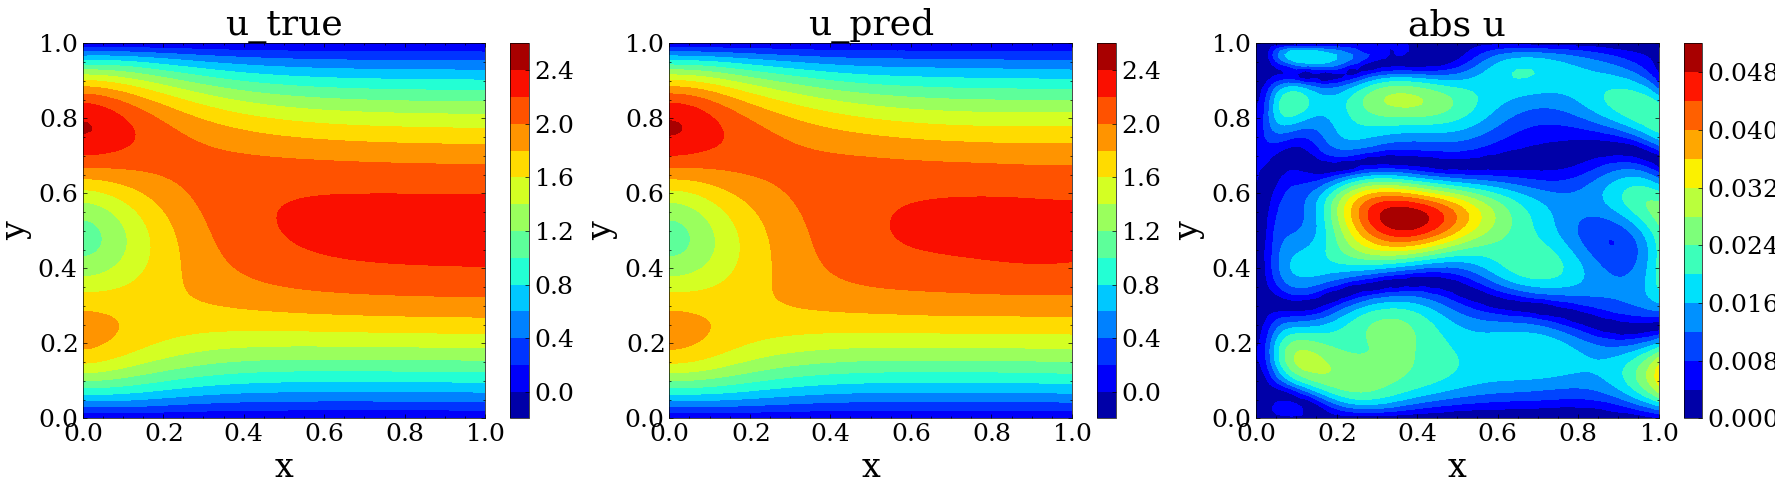

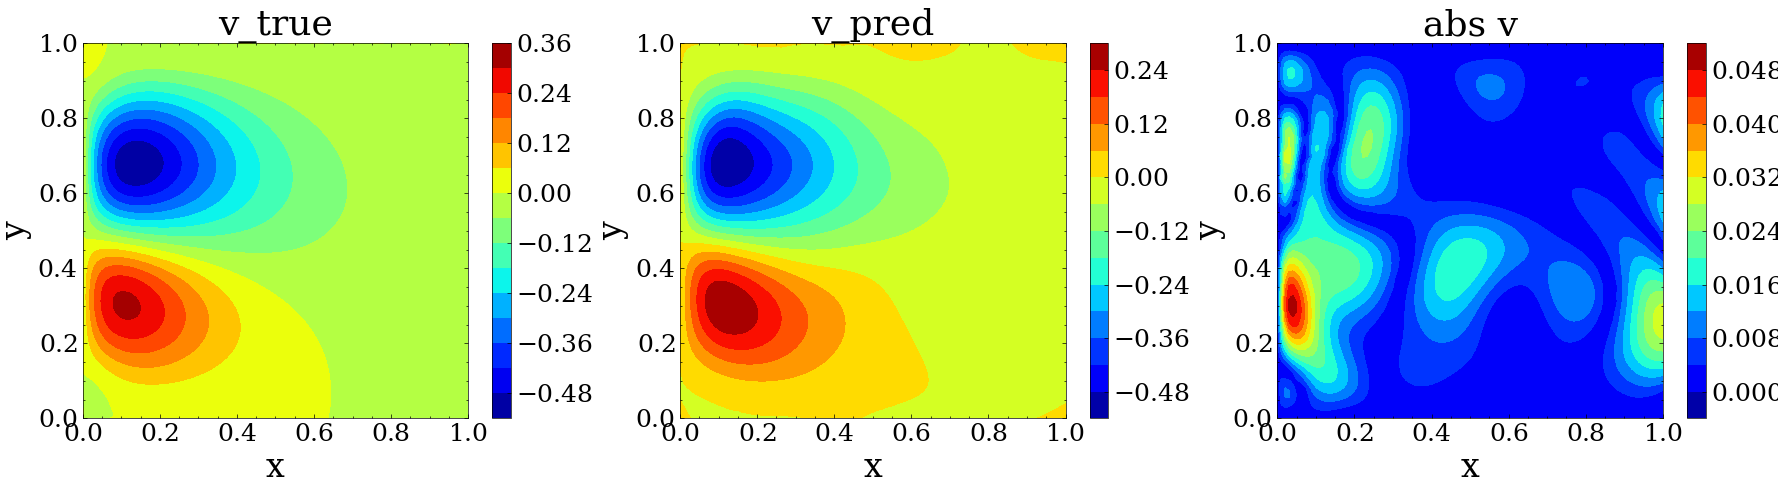

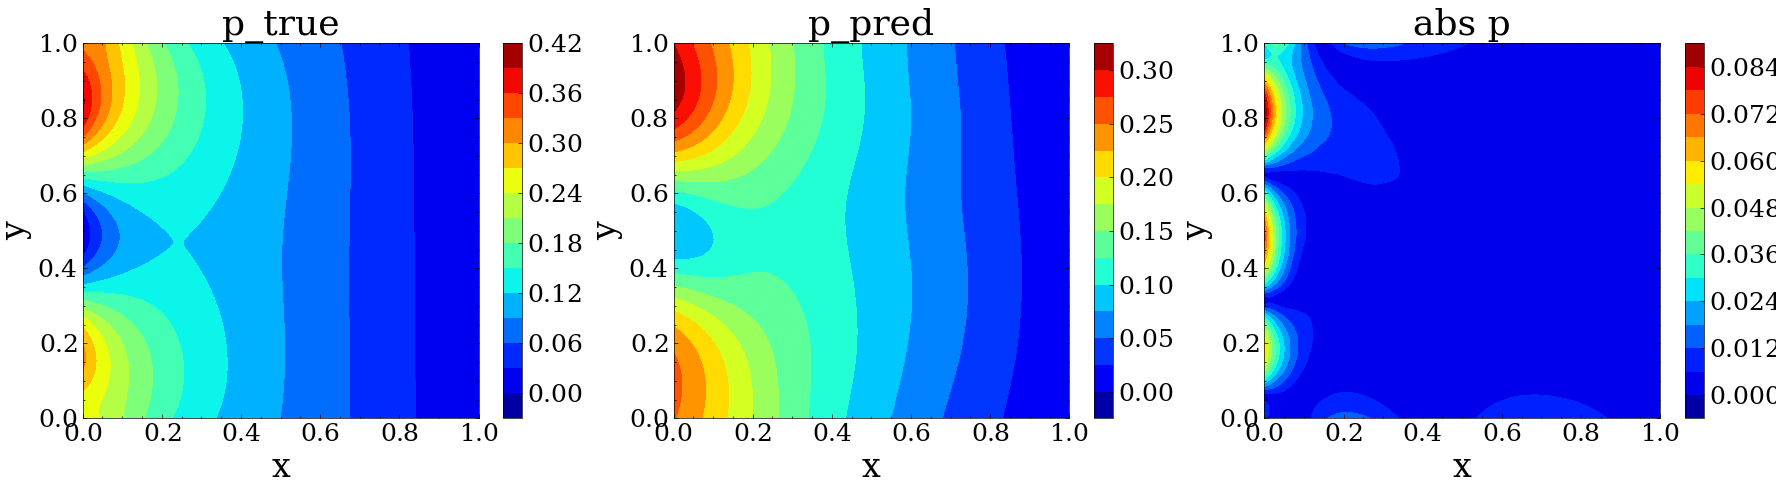

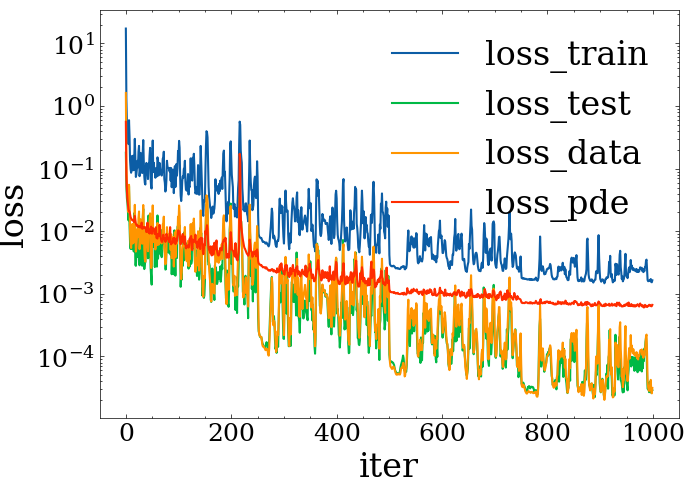

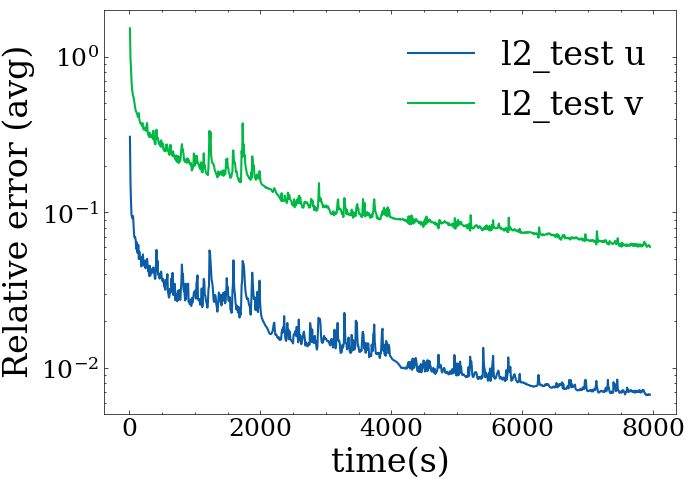

In [3]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.PIMultiONet import PIMultiONet
solver = PIMultiONet.Solver(device=device, dtype=dtype)
tag = 'tanhBeta64_X'
model_trained = solver.loadModel(path=f'saved_models/PI{netType}_{tag}/', name=f'model_pimultionet_final')

###############################
# make prediction
###############################
def get_values(x_device, a_device):
    psi = model_trained['psi'](x_device, a_device)
    dpsi = grad(inputs=x_device, outputs=psi, grad_outputs=torch.ones_like(psi), 
                create_graph=True)[0]
    u, v = dpsi[...,1:2], -dpsi[...,0:1]
    p = model_trained['p'](x_device, a_device)
    
    return u, v, p
#
beta_pred = model_trained['enc'](a_test.to(device))
x_var = Variable(x_test.to(device), requires_grad=True)
u_pred, v_pred, p_pred = get_values(x_var, beta_pred)
#
u_pred = u_pred.detach().cpu()
v_pred = v_pred.detach().cpu()
p_pred = p_pred.detach().cpu()
u_test, v_test = uv_test[...,0:1], uv_test[...,1:2]
#
print('The shape of u_pred:', u_pred.shape)
print('The shape of v_pred:', v_pred.shape)
print('The l2 error u is:', solver.getError(u_pred, u_test))
print('The l2 error v is:', solver.getError(v_pred, v_test))
print('The l2 error p is:', solver.getError(p_pred, p_test))
inx = 0
######################################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(x_test[inx], [u_test[inx], u_pred[inx], torch.abs(u_pred[inx]-u_test[inx])], 
                  ['u_true', 'u_pred', 'abs u'], lb=[0., 0.], ub=[1.,1.])
Plot.show_2d_list(x_test[inx], [v_test[inx], v_pred[inx], torch.abs(v_pred[inx]-v_test[inx])], 
                  ['v_true', 'v_pred', 'abs v'], lb=[0., 0.], ub=[1.,1.])
Plot.show_2d_list(x_test[inx], [p_test[inx], p_pred[inx], torch.abs(p_pred[inx]-p_test[inx])], 
                  ['p_true', 'p_pred', 'abs p'], lb=[0., 0.], ub=[1.,1.])
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/PI{netType}_{tag}/', name='loss_pimultionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], 
                ['l2_test u', 'l2_test v'])